In [ ]:
from ppo_agent import Agent
from environment import Environment

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch

In [ ]:
iterations = 2000               # max number of training iterations
gamma = 0.99                    # Discound factor
nsteps = 2048                   # Number of steps collected at each training step
ratio_clip = 0.2                # Ratio used for clipping the approximate gradient (from importance sampling)
nbatchs = 32                    # Batch size
epochs = 10                     # Number of episodes collected at each training step
gradient_clip = 0.5             # Parameter that defines how to clip gradients
lrate = 2e-4                    # Initial Learning rate
lrate_schedule = lambda it: max(0.995 ** it, 0.01)    # Function defining how learning rate decays
log_each = 1
beta = 0.0
gae_tau = 0.95
decay_steps = None
solved = 100.0 #2000.0
weight_decay = 0
out_file = 'checkpoints/crawler_ppo.ckpt'
#restore = 'checkpoints/crawler_ppo323.ckpt'
restore = None

In [ ]:
agent = Agent(
        env_name = "Crawler.x86_64",
        nsteps=nsteps,
        gamma=gamma,
        epochs=epochs,
        nbatchs=nbatchs,
        ratio_clip=ratio_clip,
        lrate=lrate,
        lrate_schedule=lrate_schedule,
        weight_decay=weight_decay,
        gradient_clip=gradient_clip,
        beta=beta,
        gae_tau=gae_tau,
        restore=restore
    )

In [ ]:
def train(agent, iterations=1000, log_each=10, solved=90, out_file=None):
    rewards = []
    last_saved = 0
    for it in range(iterations):
        agent.step()

        if len(agent.episodes_reward) >= 100:
            r = agent.episodes_reward[:-101:-1]
            rewards.append((agent.steps, min(r), max(r), np.mean(r), np.std(r)))

        if (it+1) % log_each == 0:
            summary = ''
            #pylint: disable=line-too-long
            if rewards:
                mean = rewards[-1][3]
                minimum = rewards[-1][1]
                maximum = rewards[-1][2]
                summary = f', Rewards: {mean:.2f}/{rewards[-1][4]:.2f}/{minimum:.2f}/{maximum:.2f} mean/std/min/max'
                if out_file and mean >= solved and mean > last_saved:
                    last_saved = mean
                    agent.save(out_file)
                    agent.save('checkpoints/crawler_ppo' + str(it+1)+'.ckpt') # Save with a different name to evauluate different iterations
                    summary += " (saved)"
                scores = np.array(rewards)[:,3]
                np.savez("scores_crawler.npz",scores)
            print(f"Iteration: {it+1:d}, Episodes: {len(agent.episodes_reward)}, Steps: {agent.steps:d}, lrate: {agent.running_lrate:.2E}, Clip: {agent.ratio_clip:.3f}{summary}")
    return scores


Iteration: 1, Episodes: 292, Steps: 24576, lrate: 2.00E-04, Clip: 0.200, Rewards: -0.73/12.33/-46.21/42.93 mean/std/min/max
Iteration: 2, Episodes: 572, Steps: 49152, lrate: 1.99E-04, Clip: 0.200, Rewards: 1.62/8.85/-29.81/23.07 mean/std/min/max
Iteration: 3, Episodes: 812, Steps: 73728, lrate: 1.98E-04, Clip: 0.200, Rewards: 3.43/11.69/-44.31/41.15 mean/std/min/max
Iteration: 4, Episodes: 1014, Steps: 98304, lrate: 1.97E-04, Clip: 0.200, Rewards: 7.14/14.03/-15.75/58.23 mean/std/min/max
Iteration: 5, Episodes: 1214, Steps: 122880, lrate: 1.96E-04, Clip: 0.200, Rewards: 8.40/16.81/-40.22/66.68 mean/std/min/max
Iteration: 6, Episodes: 1389, Steps: 147456, lrate: 1.95E-04, Clip: 0.200, Rewards: 10.04/18.03/-17.03/84.72 mean/std/min/max
Iteration: 7, Episodes: 1534, Steps: 172032, lrate: 1.94E-04, Clip: 0.200, Rewards: 18.16/20.59/-15.19/92.84 mean/std/min/max
Iteration: 8, Episodes: 1688, Steps: 196608, lrate: 1.93E-04, Clip: 0.200, Rewards: 19.36/22.76/-29.72/101.25 mean/std/min/max
Ite

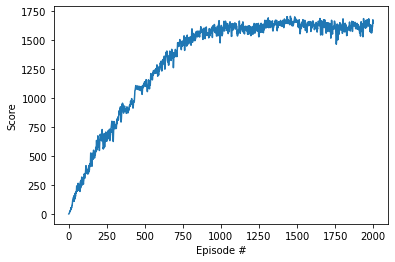

In [5]:
scores = train(agent, iterations=iterations, log_each=log_each,
          solved=solved, out_file=out_file)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()